In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 27s 332ms/step - loss: 0.3145 - root_mean_squared_error: 0.5608 - val_loss: 0.1628 - val_root_mean_squared_error: 0.4035
Epoch 2/50
53/53 [==============================] - 16s 308ms/step - loss: 0.0764 - root_mean_squared_error: 0.2763 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2680
Epoch 3/50
53/53 [==============================] - 16s 305ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2601
Epoch 4/50
53/53 [==============================] - 17s 325ms/step - loss: 0.0539 - root_mean_squared_error: 0.2321 - val_loss: 0.0620 - val_root_mean_squared_error: 0.2489
Epoch 5/50
53/53 [==============================] - 16s 313ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2401
Epoch 6/50
53/53 [==============================] - 18s 338ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040 - val_loss: 0.0446 

Epoch 28/50
53/53 [==============================] - 3s 57ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 29/50
53/53 [==============================] - 3s 58ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0705
Epoch 30/50
53/53 [==============================] - 17s 335ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 31/50
53/53 [==============================] - 17s 324ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 32/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 33/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0044 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.030657247702282 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

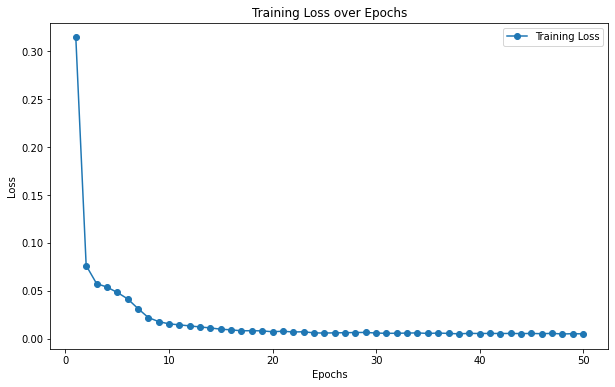

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

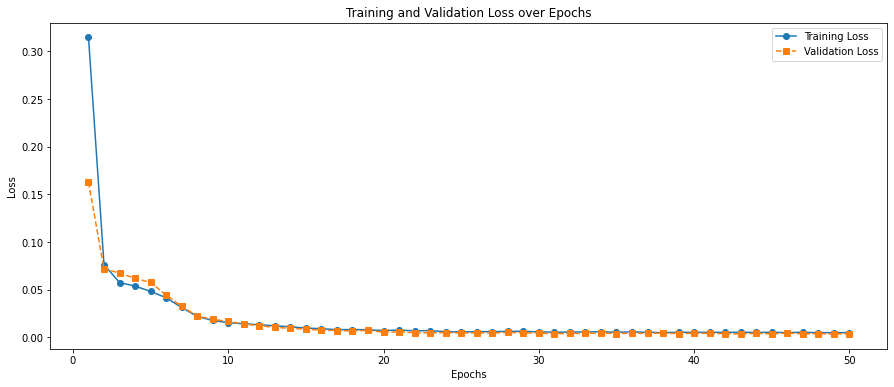

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 14ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0813825187588454
MAE : 0.05646652525796906


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.508944e+06,3499167.351
1,2.440488e+06,2715890.297
2,9.946059e+05,1053272.694
3,2.543500e+05,368862.123
4,7.860284e+05,979418.298
5,1.880179e+06,2086269.569
6,2.683258e+06,2852731.016
7,3.265396e+06,3452823.613
8,3.586934e+06,3846843.974
9,3.799348e+06,4005222.451


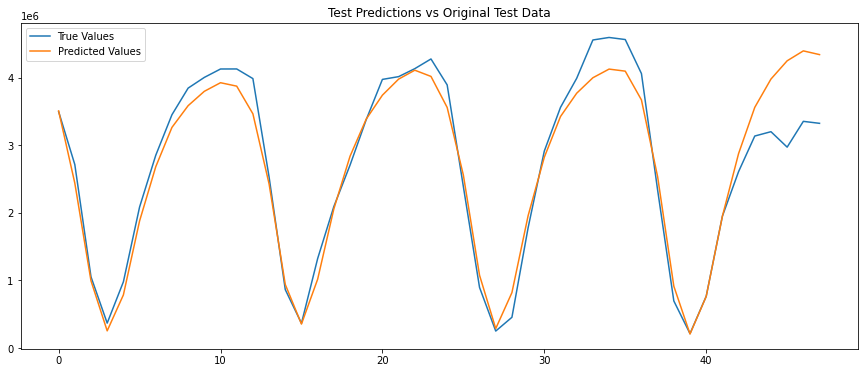

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 21ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

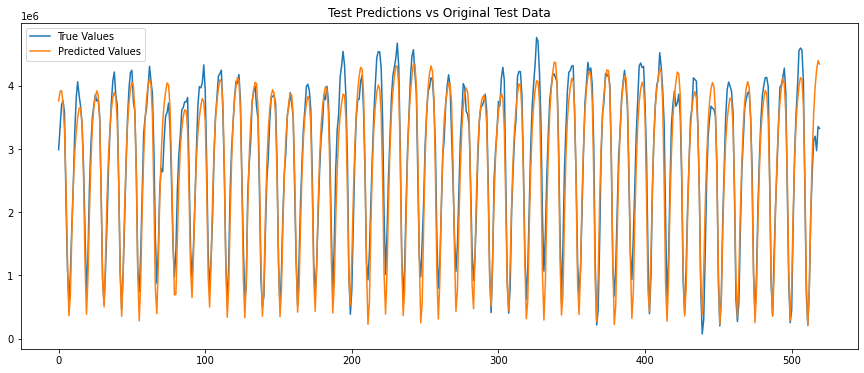

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()